# Object Identification 

This notebook tutorials the object identification methods within MontePython. These methods include the single threshold, enhanced watershed, and iterative enhanced watershed. 

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import monte_python

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["white", "red", "blue", "green", "purple", 'gray'])

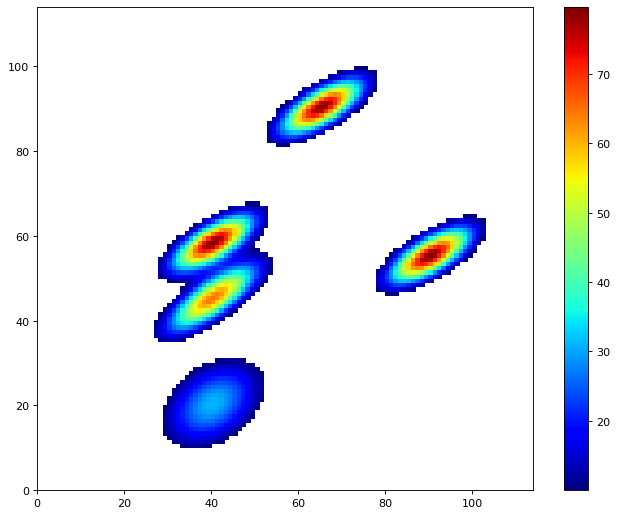

In [3]:
# Create fake storm data

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
g_len = 115
grid = np.zeros((2, g_len, g_len))
labels = np.zeros((2, g_len, g_len), dtype=int)
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
coords = np.dstack((x, y))
peak1_t0 = 1e4 * multivariate_normal(mean=[40, 45], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t0 = 1e4 * multivariate_normal(mean=[40, 58], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t0 = 1e4 * multivariate_normal(mean=[65, 90], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t0 = 1e4 * multivariate_normal(mean=[90,55], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t0 = 1e4 * multivariate_normal(mean=[40,20], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

peak1_t1 = 1e4 * multivariate_normal(mean=[50, 55], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t1 = 1e4 * multivariate_normal(mean=[45, 70], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t1 = 1e4 * multivariate_normal(mean=[75, 110], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t1 = 1e4 * multivariate_normal(mean=[95,65], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t1 = 1e4 * multivariate_normal(mean=[50, 30], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

grid[0] +=  peak1_t0+peak2_t0+peak3_t0+peak4_t0+peak5_t0
grid[1] +=  peak1_t1+peak2_t1+peak3_t1+peak4_t1+peak5_t1

plt.pcolormesh(x, y, np.ma.array(grid[0], mask=grid[0] < 10), cmap='jet', )
plt.colorbar()

## Single Threshold Method 

Let's start with a generic 2D field of quasi-discrete peaks (see above). These peaks could represent updraft helicity associated with severe storms, radar reflectivity, or intense rainfall regions, etc. MontePython can identifying this regions using a single threshold or with the more sophisicated enhanced watershed algorithm (Lakshmanan et al. 2009, Gagne et al. 2016).

To use the single threshold method, set ``method = single_threshold and params = {'bdry_thresh':N}`` where N is the given threshold. Set ``return_object_properties = True`` if you also want to return various properties of the labelled objects. In the first example, the boundary threshold is 20.

In [4]:
storm_labels, object_props = monte_python.label( input_data = grid[0],
                                   method ='single_threshold', 
                                   return_object_properties=True, 
                                   params = {'bdry_thresh':20} )

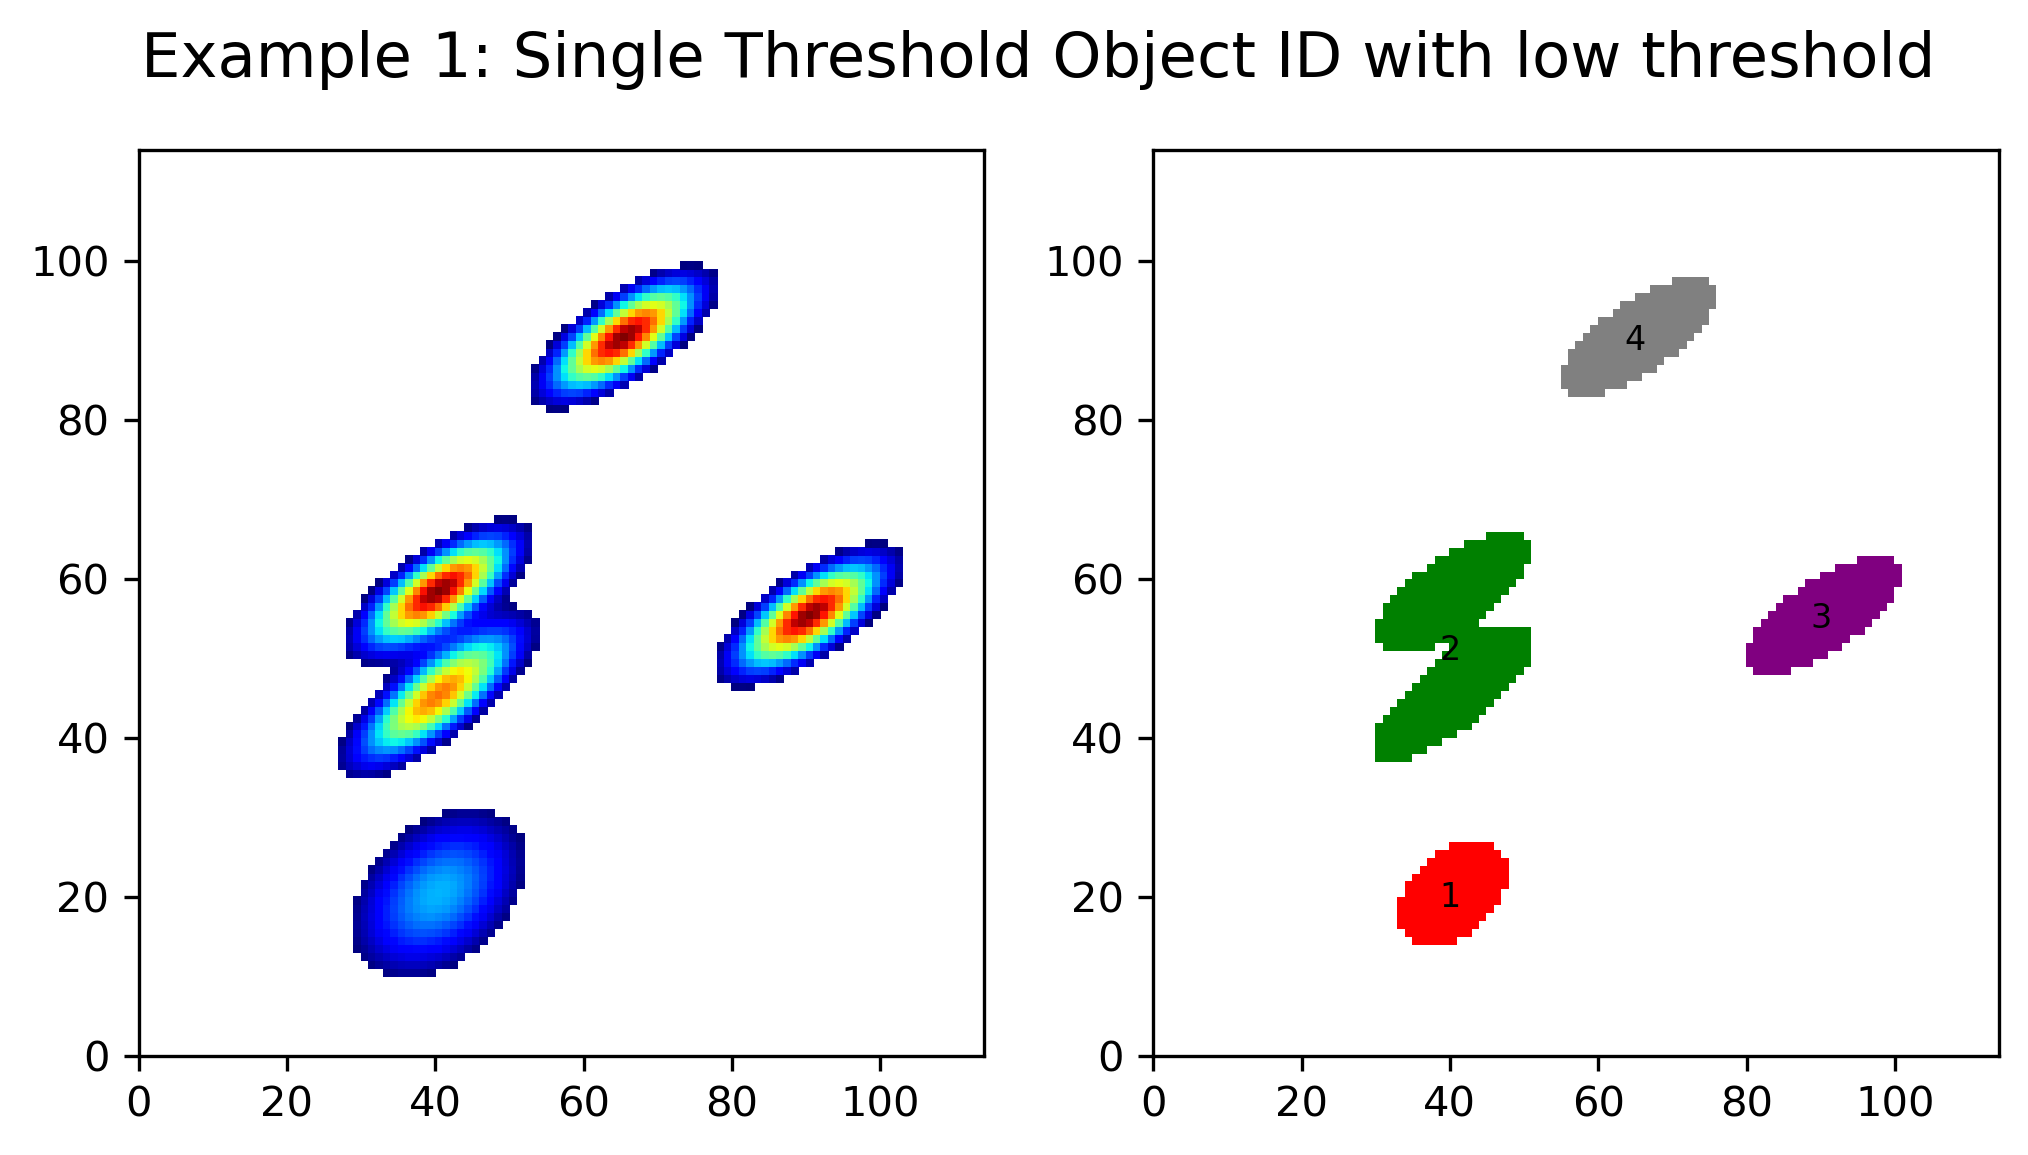

In [5]:
def label_centroid(ax, object_props):
    """Place object label on object's centroid"""
    for region in object_props:
        x_cent,y_cent = region.centroid
        x_cent=int(x_cent)
        y_cent=int(y_cent)
        xx, yy = x[x_cent,y_cent], y[x_cent,y_cent]
        fontsize = 6.5 if region.label >= 10 else 8
        ax.text(xx,yy,
                    region.label,
                    fontsize=fontsize,
                    ha='center',
                    va='center',
                    color = 'k'
                    )

fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(8,4))
fig.suptitle('Example 1: Single Threshold Object ID with low threshold', fontsize=15)

for ax, z, cm in zip(axes, [np.ma.array(grid[0], mask=grid[0] < 10), storm_labels], ['jet', cmap]):
    ax.pcolormesh(x, y, z, cmap=cm)
label_centroid(ax, object_props)    

The single threshold method performs well for discrete features, but may not separate clustered objects (e.g., the green object). Separating these features requires a higher threshold (see below). However, increasing the threshold can be restrictive (e.g., the slightly weaker object closest to the SW corner is no longer identified). Ultimately, there are pros and cons to the single threshold method.

In [6]:
# Using a threshold of 40 rather than 20
storm_labels, object_props = monte_python.label( grid[0], 
                      method ='single_threshold', 
                      return_object_properties=True, 
                      params = {'bdry_thresh':40} )

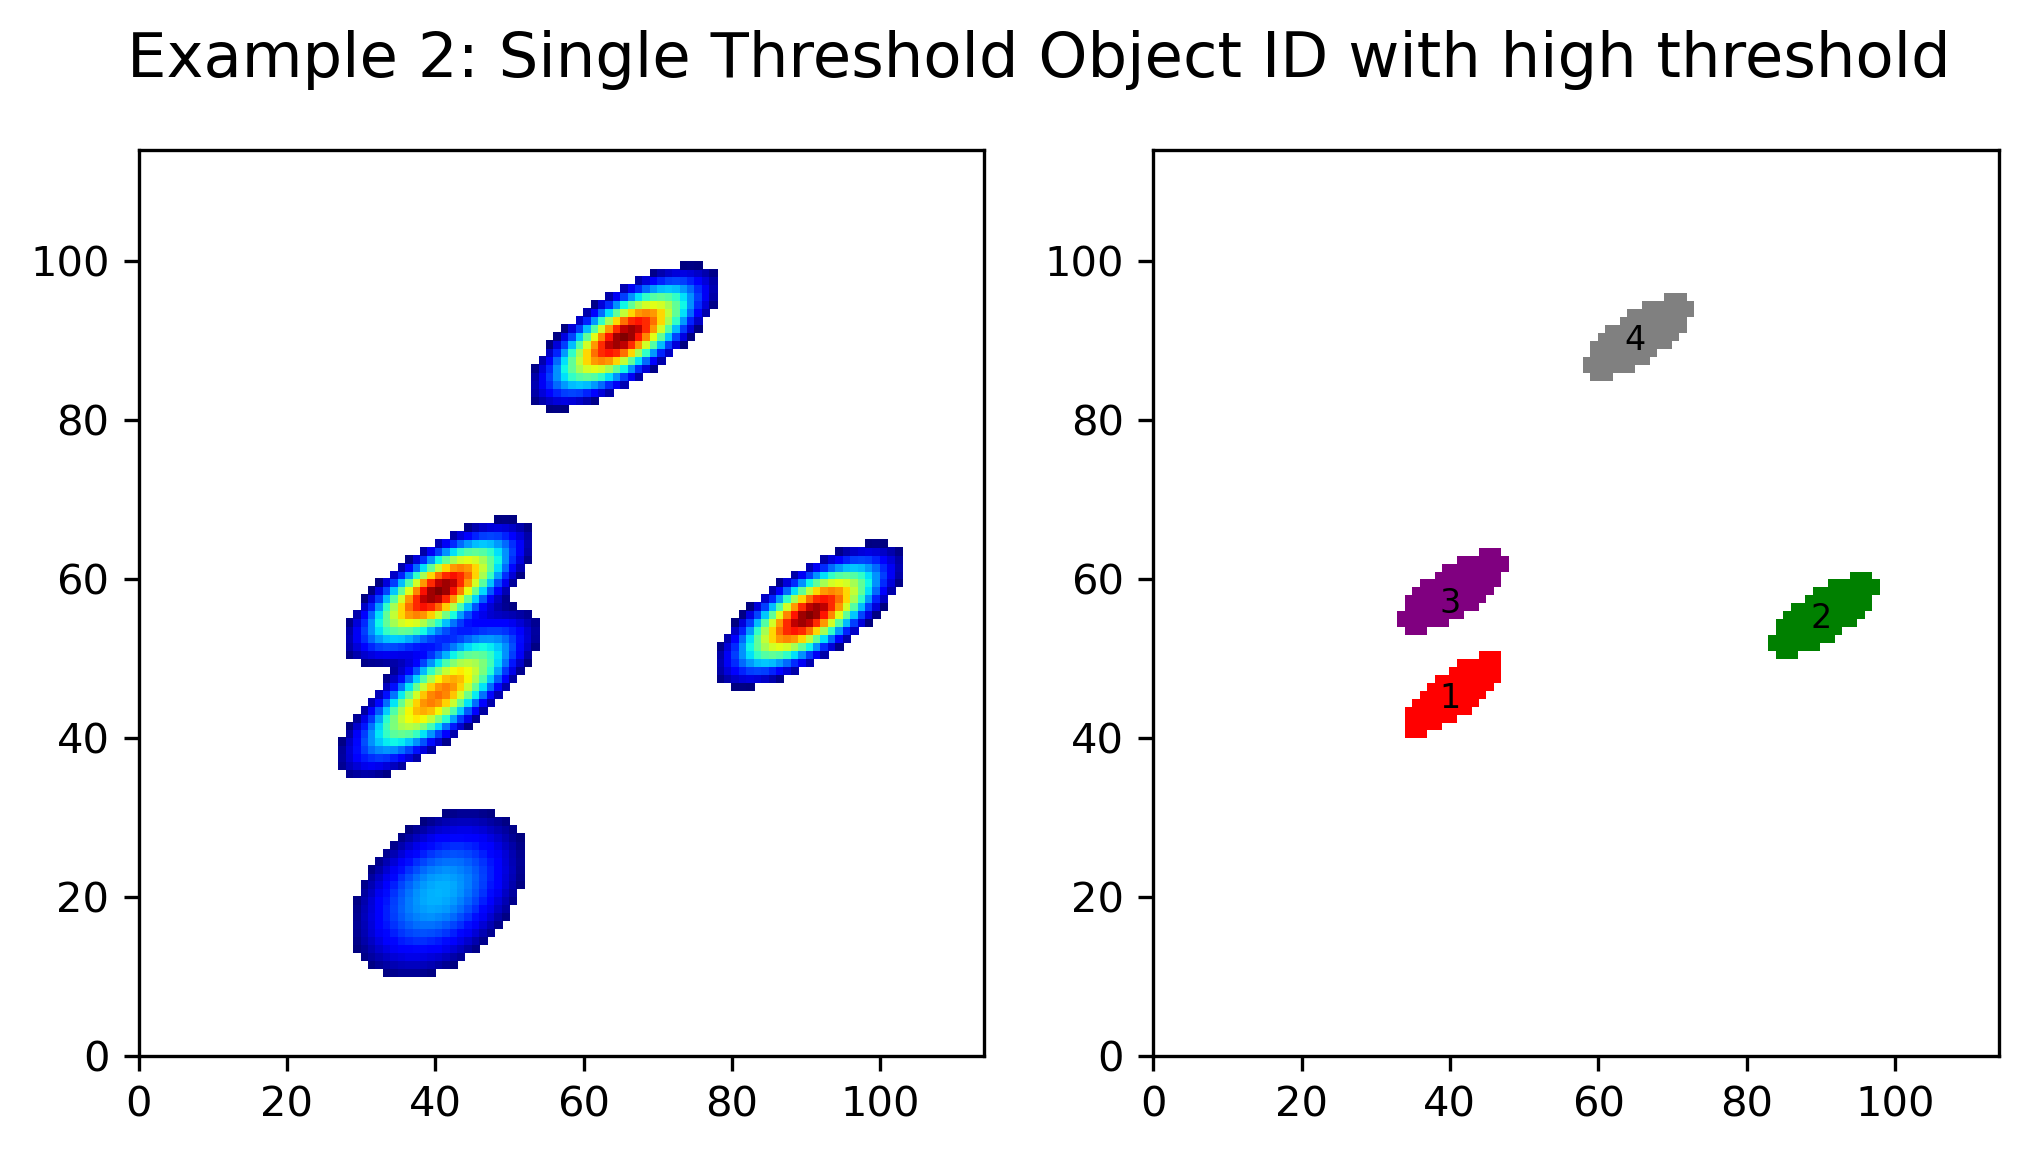

In [7]:
fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(8,4))
fig.suptitle('Example 2: Single Threshold Object ID with high threshold', fontsize=15)

for ax, z, cm in zip(axes, [np.ma.array(grid[0], mask=grid[0] < 10), storm_labels], ['jet', cmap]):
    ax.pcolormesh(x, y, z, cmap=cm)
label_centroid(ax, object_props) 

## Enhanced Watershed Method

A more sophisicated alternative is the enhanced watershed algorithm. The watershed method identifies local maxima and then grows objects pixel by pixel from a quantized version of the original field until they reach a specified area or intensity criteria (Lakshmanan et al. 2009). Objects are restricted from growing into regions less than the given minimum threshold (e.g., reflectivity > 40 dBZ) and once an object is identified, a larger region surrounding the objects is demarcated as a no-grow region for additional objects ensuring separation (i.e., the foothills region in Lakshmanan et al. 2009). Thus, the enhanced watershed algorithm is most powerful for identifying separate objects from clusters. However, the watershed algorithm does requires careful tuning to outperform the single threshold method. The different sensitivities and limitations of the watershed algorithm are provided in section 2c1 of Flora et al. (2019). In summary, the crucial parameters for the watershed algorithm are the minimum (``min_thresh``) and area (``area_threshold``) thresholds and the minimal distance between objects centers (``dist_btw_objects``). 

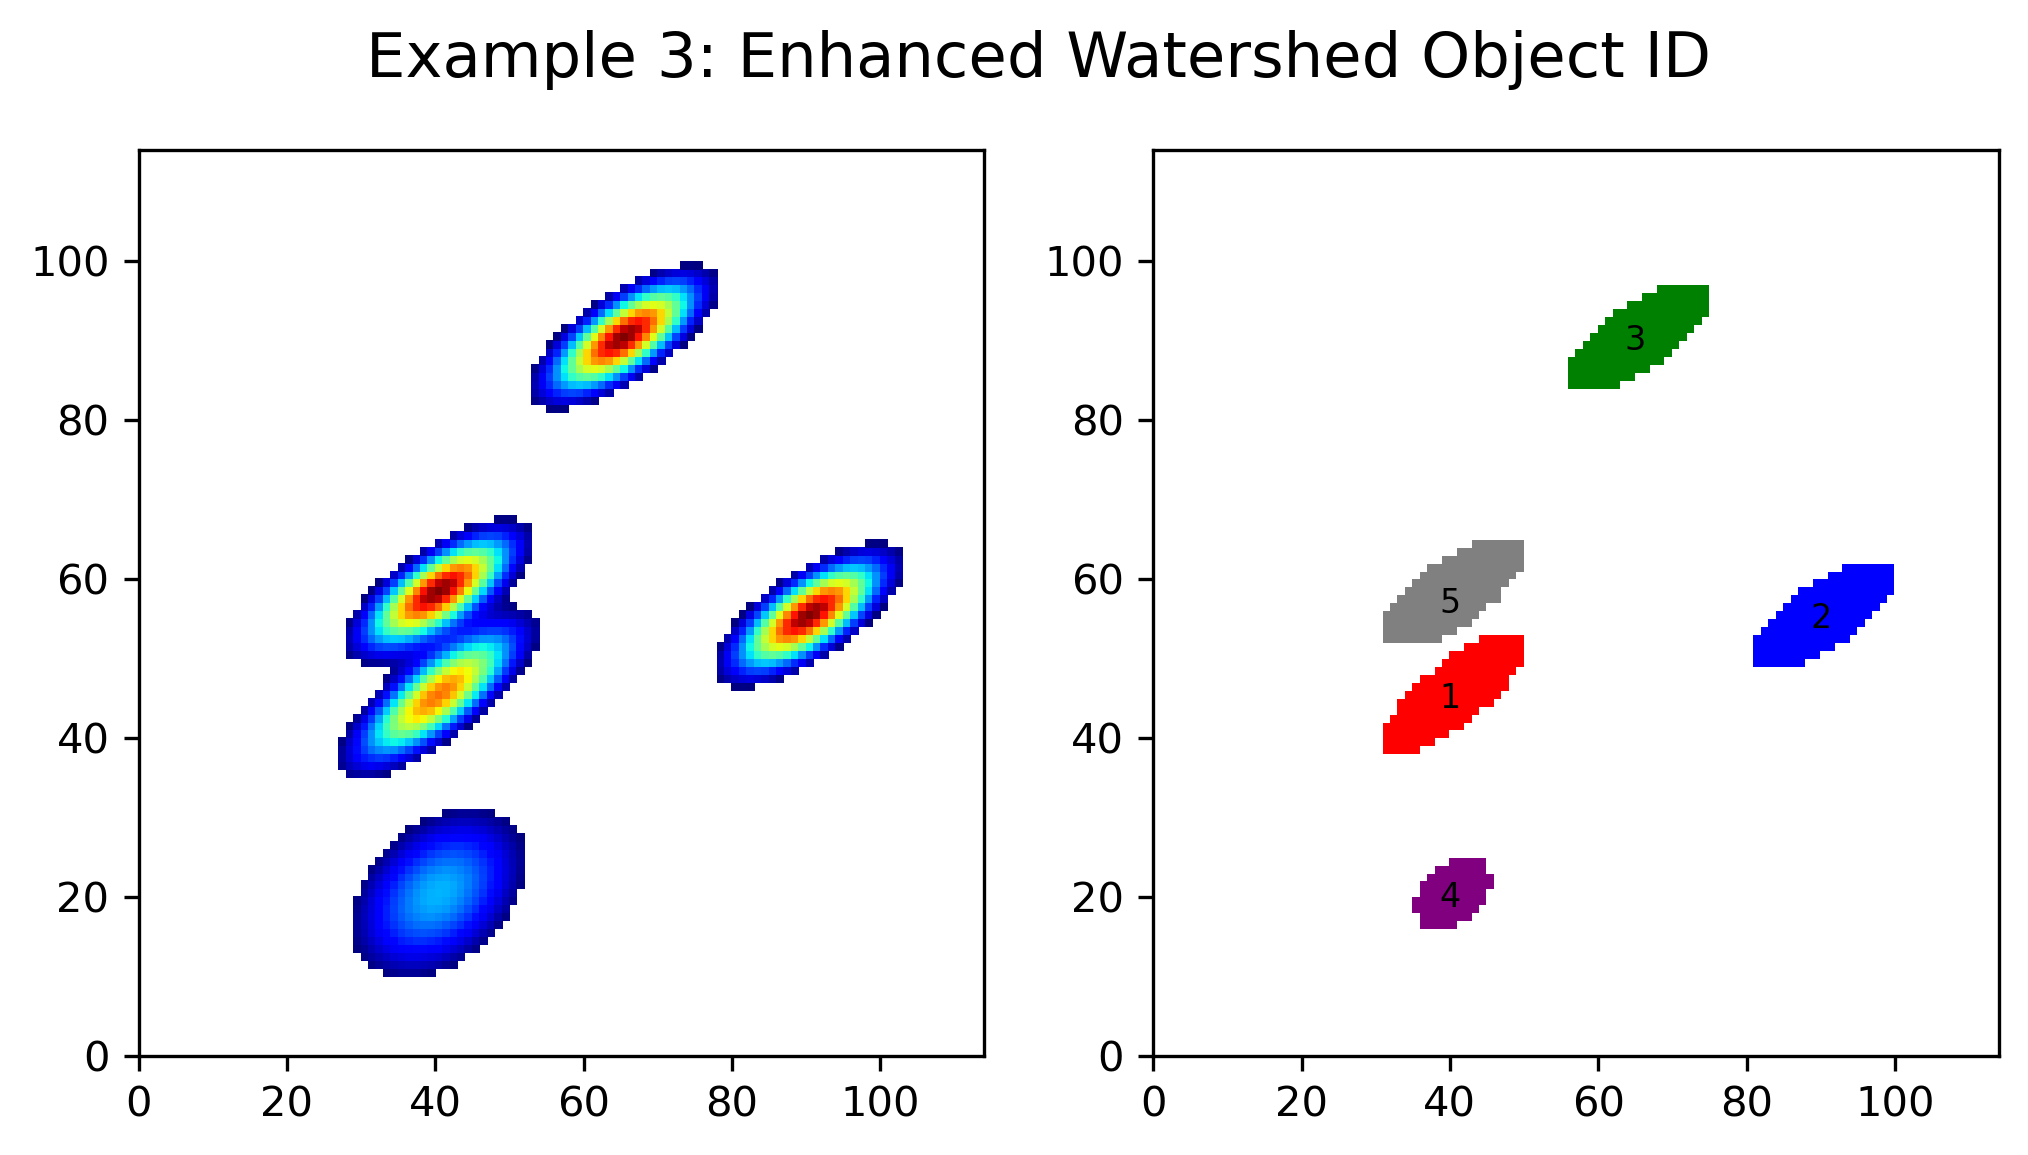

In [8]:
storm_labels, object_props = monte_python.label(  input_data = grid[0], 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = {'min_thresh':25,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 150,
                                 'dist_btw_objects': 50} 
                       )

fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(8,4))
fig.suptitle('Example 3: Enhanced Watershed Object ID', fontsize=15)

for ax, z, cm in zip(axes, [np.ma.array(grid[0], mask=grid[0] < 10), storm_labels], ['jet', cmap]):
    ax.pcolormesh(x, y, z, cmap=cm)
label_centroid(ax, object_props) 

As compared to the single threshold method, the enhanced watershed does a great job of identifying clustered objects and breaking them up. However, one drawback of the enhanced watershed is that it is sensitive to the scale of the objects (since it's main stopping criteria is object area). For example, what if wanted to maintain the original area of every object in the domain (e.g., object 4 in purple is much smaller than the area it was identified from). In the following example, we will demostrate the iterative watershed method that allows us to identify objects across at multiple scales. 

## Iterative Watershed Method 

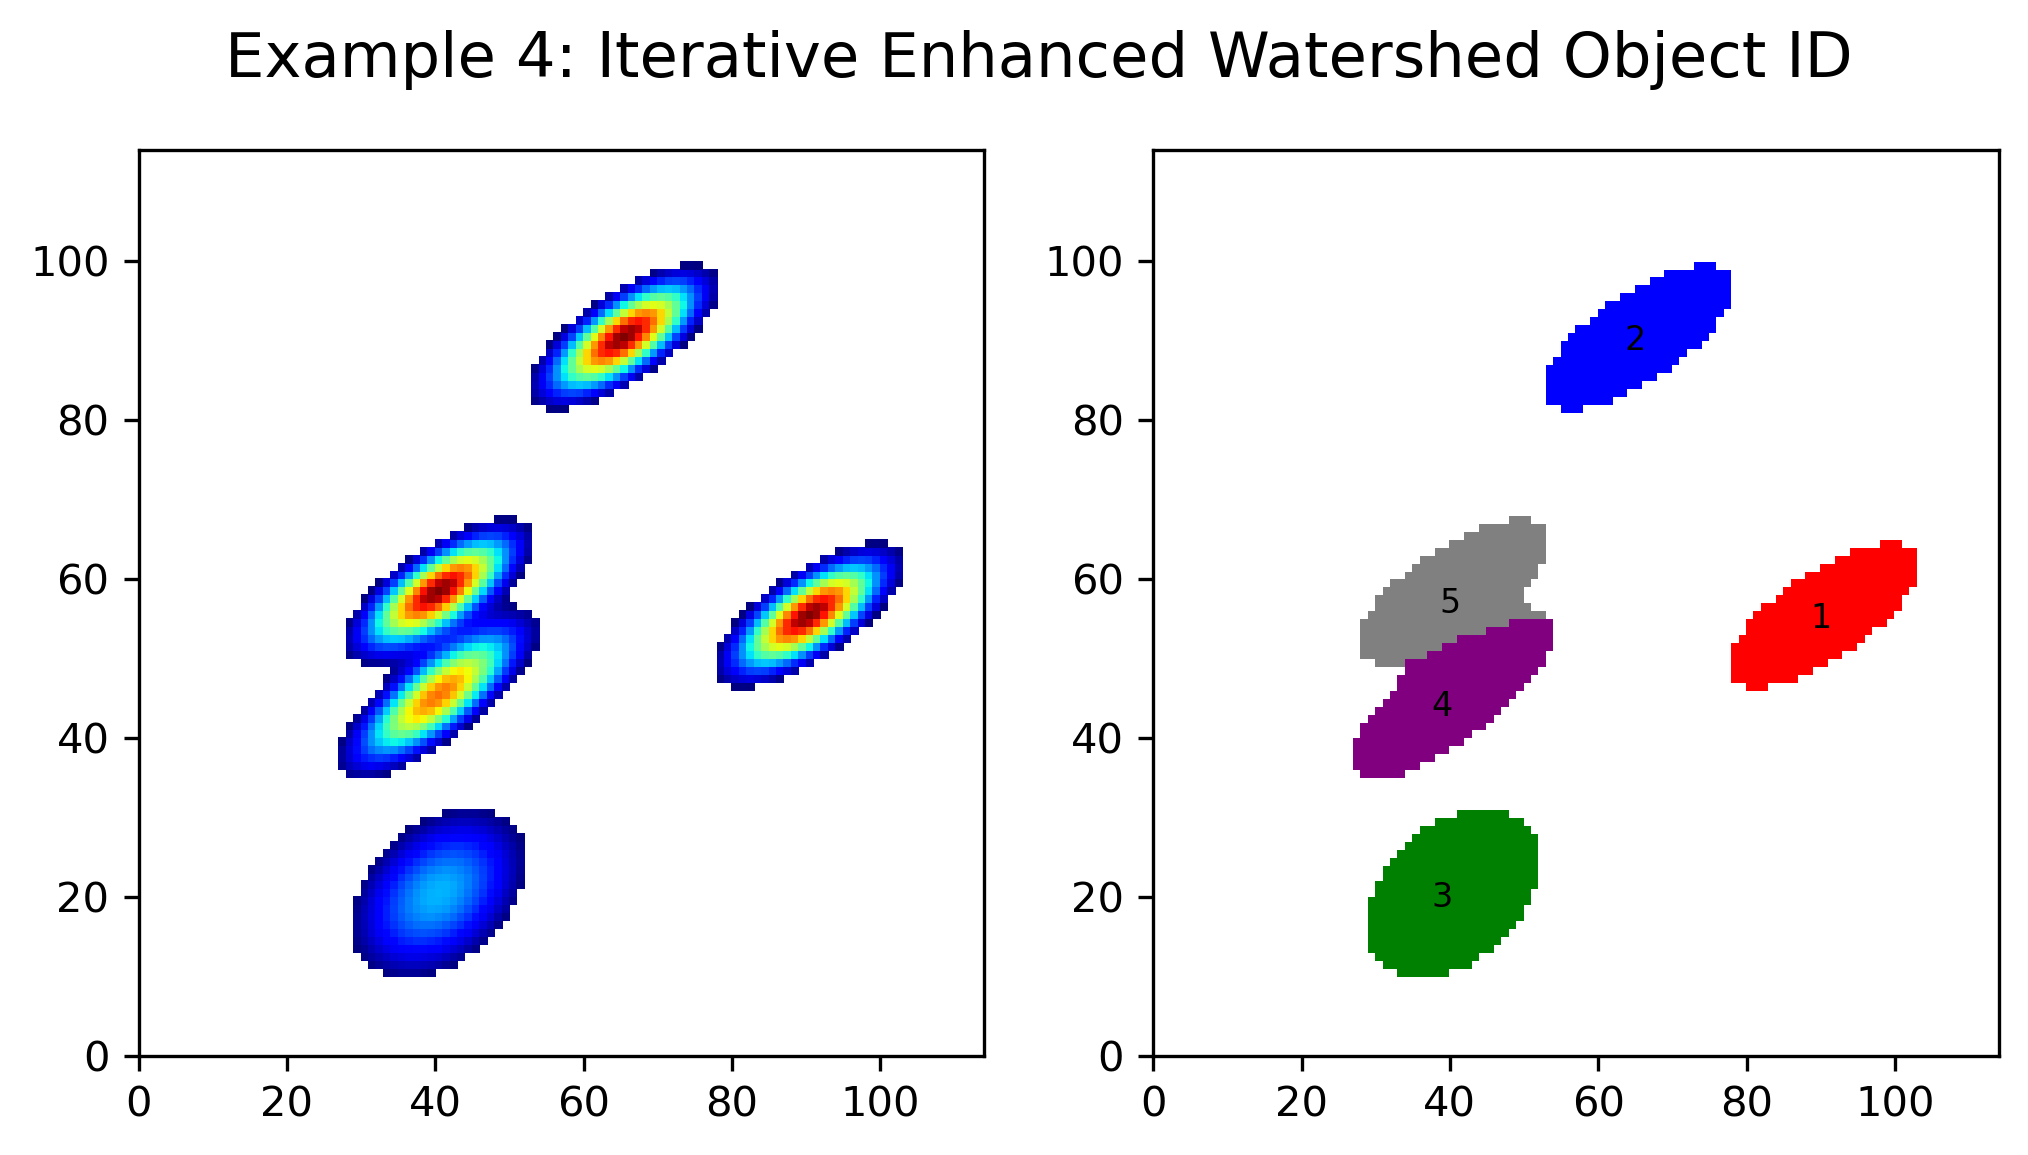

In [15]:
# For this example, we are using two iterations of the iterative watershed method. 
# However, if the expected objects existed across more spatial scales, we could introduce more
# iterations. 
param_set = [ {'min_thresh':10,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 200,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':25,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 50,
                                 'dist_btw_objects': 10} 
            ]

params = {'params': param_set }

input_data = np.where(grid[0] > 10, grid[0], 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = params,  
                       )

fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(8,4))
fig.suptitle('Example 4: Iterative Enhanced Watershed Object ID', fontsize=15)

for ax, z, cm in zip(axes, [np.ma.array(grid[0], mask=grid[0] < 10), storm_labels], ['jet', cmap]):
    ax.pcolormesh(x, y, z, cmap=cm)
label_centroid(ax, object_props) 

The iterative enhanced watershed method is capable of identifying embedded signals within clusters, but is also faithfull to the original spatial extend of a region. The biggest drawback of this method is that it may require significant tuning. 